# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [2]:
import pybamm
import matplotlib.pyplot as plt

## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [3]:
parameter_values = pybamm.ParameterValues("Mohtat2020")
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

We initialize the concentration in each electrode at 100% State of Charge

In [4]:
# Calculate stoichiometries at 100% SOC
parameter_values.set_initial_stoichiometries(1);

We can now simulate a single CCCV cycle using the `Experiment` class (see [this notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/docs/source/examples/notebooks/getting_started/tutorial-5-run-experiments.ipynb) for more details)

In [5]:
pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C until 3V",
            "Rest for 1 hour",
            "Charge at 1C until 4.2V",
            "Hold at 4.2V until C/50",
        )
    ]
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2025-01-31 14:49:41.540 - [NOTICE] logger.func(7): Cycle 1/1 (27.375 us elapsed) --------------------
2025-01-31 14:49:41.540 - [NOTICE] logger.func(7): Cycle 1/1, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:41.569 - [NOTICE] logger.func(7): Cycle 1/1, step 2/4: Rest for 1 hour
2025-01-31 14:49:41.585 - [NOTICE] logger.func(7): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2025-01-31 14:49:41.608 - [NOTICE] logger.func(7): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2025-01-31 14:49:41.644 - [NOTICE] logger.func(7): Finish experiment simulation, took 104.192 ms


Alternatively, we can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [6]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C until 3V",
            "Rest for 1 hour",
            "Charge at 1C until 4.2V",
            "Hold at 4.2V until C/50",
        )
    ]
    * 500,
    termination="80% capacity",
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2025-01-31 14:49:42.052 - [NOTICE] logger.func(7): Cycle 1/500 (26.250 us elapsed) --------------------
2025-01-31 14:49:42.052 - [NOTICE] logger.func(7): Cycle 1/500, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:42.074 - [NOTICE] logger.func(7): Cycle 1/500, step 2/4: Rest for 1 hour
2025-01-31 14:49:42.091 - [NOTICE] logger.func(7): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2025-01-31 14:49:42.114 - [NOTICE] logger.func(7): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2025-01-31 14:49:42.187 - [NOTICE] logger.func(7): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2025-01-31 14:49:42.187 - [NOTICE] logger.func(7): Cycle 2/500 (135.096 ms elapsed) --------------------
2025-01-31 14:49:42.187 - [NOTICE] logger.func(7): Cycle 2/500, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:42.194 - [NOTICE] logger.func(7): Cycle 2/500, step 2/4: Rest for 1 hour
2025-01-31 14:49:42.199 - [NOTICE] logger.func(7): Cycle 2/500, step 3/4: Charge at 1C until 4.2

### Summary variables

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [7]:
sol.plot(["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=147.08000909620864, step=1.4708000909620864)…

Instead, we plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle. This can be achieved by using `plot_summary_variables` method of pybamm, which can also be used to compare "summary variables" extracted from 2 or more solutions.

In [8]:
sorted(sol.summary_variables.all_variables)

['Capacity [A.h]',
 'Capacity [mA.h.cm-2]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to negative SEI [A.h]',
 'Change in loss of capacity to negative SEI on cracks [A.h]',
 'Change in loss of capacity to negative lithium plating [A.h]',
 'Change in loss of capacity to positive SEI [A.h]',
 'Change in loss of capacity to positive SEI on cracks [A.h]',
 'Change in loss of capacity to positive lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to negative SEI [mol]',
 'Change in loss of lithium to negative SEI on cracks [mol]',
 'Change in loss of lithium to negative lithium plating [mol]',
 'Change in loss of lithium to positive SEI [mol]',
 'Change in loss of lithium to positive SEI on cracks [mol]',
 'Change in loss of li

The "summary variables" associated with a particular model can also be accessed as a list (which can then be edited) -

In [9]:
spm.summary_variables

['Time [s]',
 'Time [h]',
 'Throughput capacity [A.h]',
 'Throughput energy [W.h]',
 'Loss of lithium inventory [%]',
 'Loss of lithium inventory, including electrolyte [%]',
 'Total lithium [mol]',
 'Total lithium in electrolyte [mol]',
 'Total lithium in particles [mol]',
 'Total lithium lost [mol]',
 'Total lithium lost from particles [mol]',
 'Total lithium lost from electrolyte [mol]',
 'Loss of lithium to negative SEI [mol]',
 'Loss of capacity to negative SEI [A.h]',
 'Loss of lithium to positive SEI [mol]',
 'Loss of capacity to positive SEI [A.h]',
 'Total lithium lost to side reactions [mol]',
 'Total capacity lost to side reactions [A.h]',
 'Local ECM resistance [Ohm]',
 'Negative electrode capacity [A.h]',
 'Loss of active material in negative electrode [%]',
 'Total lithium in negative electrode [mol]',
 'Loss of lithium to negative lithium plating [mol]',
 'Loss of capacity to negative lithium plating [A.h]',
 'Loss of lithium to negative SEI on cracks [mol]',
 'Loss of c

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

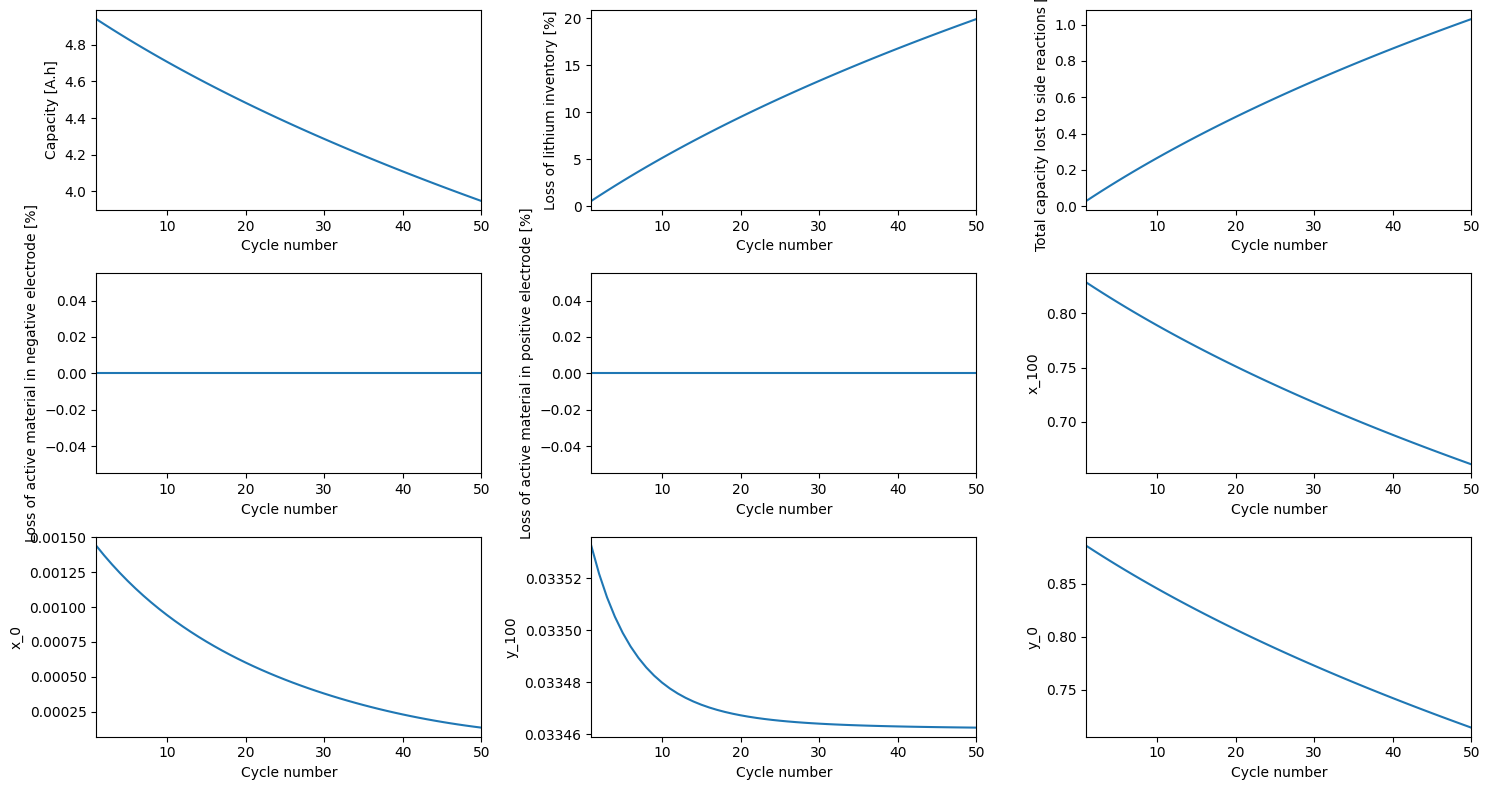

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [10]:
pybamm.plot_summary_variables(sol)

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [11]:
# With integer
sol_int = sim.solve(save_at_cycles=5)
# With list
sol_list = sim.solve(save_at_cycles=[30, 45, 55])

2025-01-31 14:49:44.715 - [NOTICE] logger.func(7): Cycle 1/500 (10.125 us elapsed) --------------------
2025-01-31 14:49:44.716 - [NOTICE] logger.func(7): Cycle 1/500, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:44.725 - [NOTICE] logger.func(7): Cycle 1/500, step 2/4: Rest for 1 hour
2025-01-31 14:49:44.729 - [NOTICE] logger.func(7): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2025-01-31 14:49:44.735 - [NOTICE] logger.func(7): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2025-01-31 14:49:44.751 - [NOTICE] logger.func(7): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2025-01-31 14:49:44.751 - [NOTICE] logger.func(7): Cycle 2/500 (36.161 ms elapsed) --------------------
2025-01-31 14:49:44.751 - [NOTICE] logger.func(7): Cycle 2/500, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:44.757 - [NOTICE] logger.func(7): Cycle 2/500, step 2/4: Rest for 1 hour
2025-01-31 14:49:44.761 - [NOTICE] logger.func(7): Cycle 2/500, step 3/4: Charge at 1C until 4.2V

In [12]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [13]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [14]:
sol_list.cycles[44].plot(["Current [A]", "Voltage [V]"])

interactive(children=(FloatSlider(value=130.34639035078675, description='t', max=133.1499511375578, min=130.34…

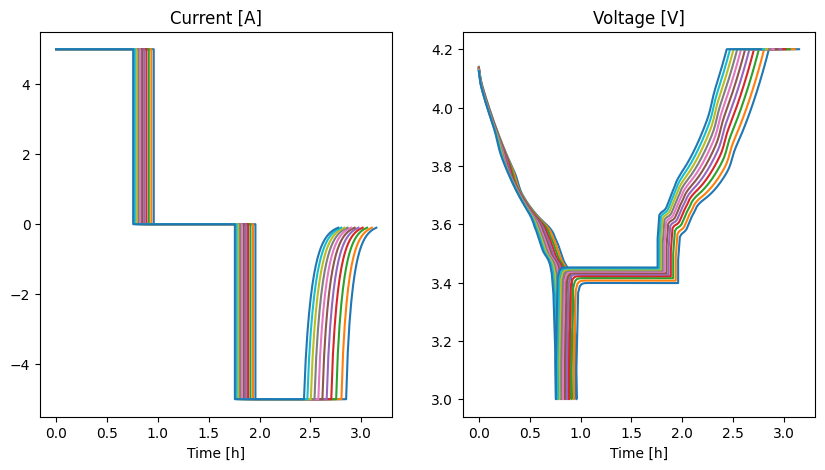

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

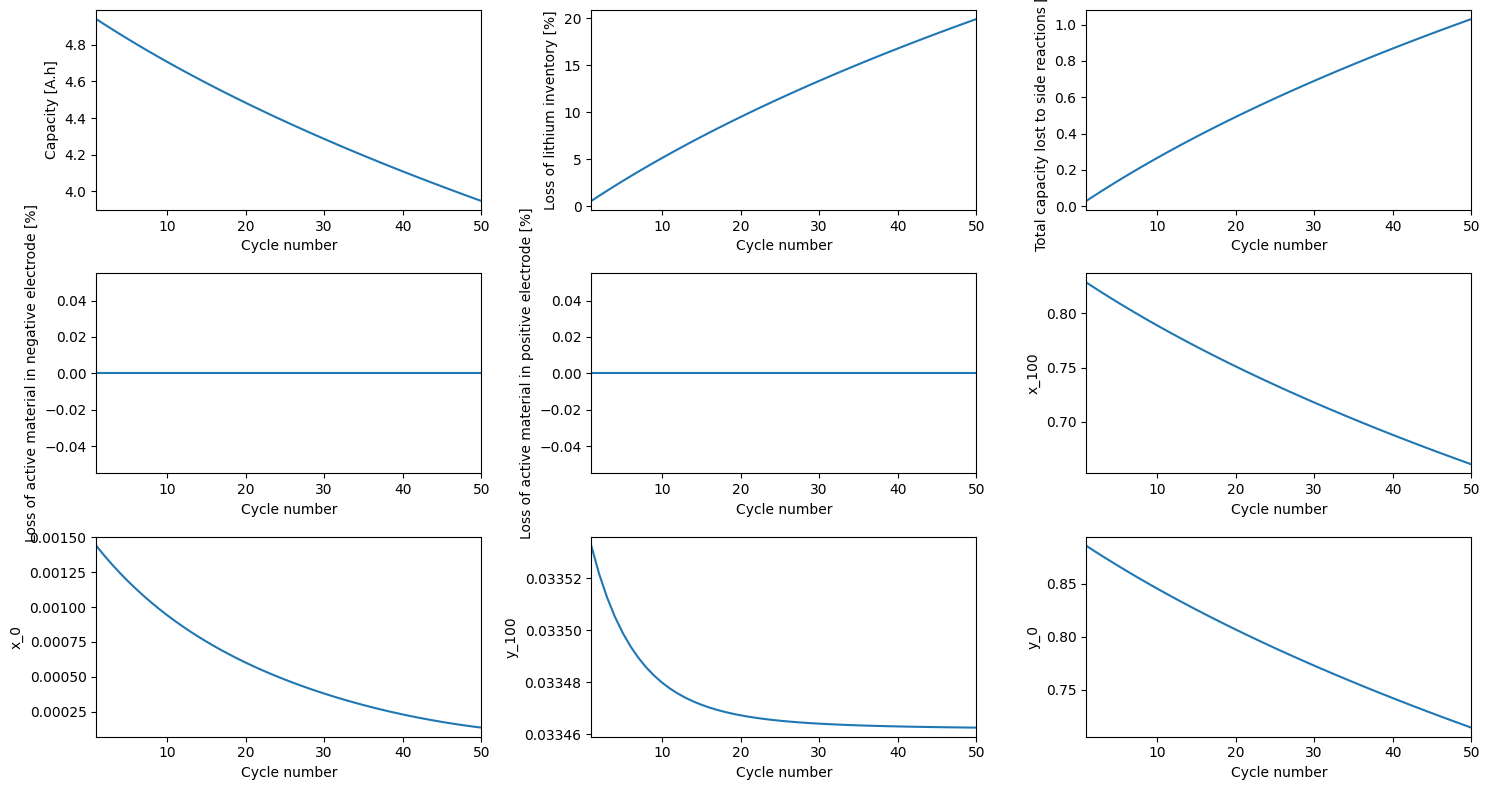

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [16]:
pybamm.plot_summary_variables(sol_list)

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [17]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at 1C until 3V",
            "Rest for 1 hour",
            "Charge at 1C until 4.2V",
            "Hold at 4.2V until C/50",
        )
    ]
    * 10,
    termination="80% capacity",
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2025-01-31 14:49:49.226 - [NOTICE] logger.func(7): Cycle 1/10 (22.792 us elapsed) --------------------
2025-01-31 14:49:49.227 - [NOTICE] logger.func(7): Cycle 1/10, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:49.249 - [NOTICE] logger.func(7): Cycle 1/10, step 2/4: Rest for 1 hour
2025-01-31 14:49:49.265 - [NOTICE] logger.func(7): Cycle 1/10, step 3/4: Charge at 1C until 4.2V
2025-01-31 14:49:49.289 - [NOTICE] logger.func(7): Cycle 1/10, step 4/4: Hold at 4.2V until C/50
2025-01-31 14:49:49.351 - [NOTICE] logger.func(7): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2025-01-31 14:49:49.352 - [NOTICE] logger.func(7): Cycle 2/10 (125.450 ms elapsed) --------------------
2025-01-31 14:49:49.352 - [NOTICE] logger.func(7): Cycle 2/10, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:49.360 - [NOTICE] logger.func(7): Cycle 2/10, step 2/4: Rest for 1 hour
2025-01-31 14:49:49.364 - [NOTICE] logger.func(7): Cycle 2/10, step 3/4: Charge at 1C until 4.2V
2025-01

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [18]:
sol2 = sim.solve(starting_solution=sol)

2025-01-31 14:49:49.615 - [NOTICE] logger.func(7): Cycle 11/20 (14.667 us elapsed) --------------------
2025-01-31 14:49:49.615 - [NOTICE] logger.func(7): Cycle 11/20, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:49.666 - [NOTICE] logger.func(7): Cycle 11/20, step 2/4: Rest for 1 hour
2025-01-31 14:49:49.672 - [NOTICE] logger.func(7): Cycle 11/20, step 3/4: Charge at 1C until 4.2V
2025-01-31 14:49:49.682 - [NOTICE] logger.func(7): Cycle 11/20, step 4/4: Hold at 4.2V until C/50
2025-01-31 14:49:49.696 - [NOTICE] logger.func(7): Capacity is now 4.684 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2025-01-31 14:49:49.696 - [NOTICE] logger.func(7): Cycle 12/20 (81.497 ms elapsed) --------------------
2025-01-31 14:49:49.696 - [NOTICE] logger.func(7): Cycle 12/20, step 1/4: Discharge at 1C until 3V
2025-01-31 14:49:49.702 - [NOTICE] logger.func(7): Cycle 12/20, step 2/4: Rest for 1 hour
2025-01-31 14:49:49.705 - [NOTICE] logger.func(7): Cycle 12/20, step 3/4: Charge at 1C until 4.2V

We have now simulated 20 cycles

In [19]:
len(sol2.cycles)

20

## References

The relevant papers for this notebook are:

In [20]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-264